In [1]:
import transformers
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Trainer, TrainingArguments
import torch
from PIL import Image
import torch.nn as nn
import cv2
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
# from ultralytics import YOLO
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import requests
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import json

import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import OrderedDict

from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast

### Train

In [2]:
pip install transformers datasets torch torchvision pyvi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 37.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
print(torch.__version__)
print(transformers.__version__)
print(sklearn.__version__)
print(torchvision.__version__)
print(cv2.__version__)


2.5.1+cu121
4.47.0
1.2.2
0.20.1+cu121
4.10.0


### Get data from API

In [4]:
# # Đọc dữ liệu được thu thập và lưu trữ MinIO
# data_custom = pd.read_csv("/kaggle/input/custom-traffic-data/imcp.refined.csv")
# data_custom = data_custom[["s3_url", "tokenized_caption"]].rename(columns={"s3_url": "url", "tokenized_caption": "caption"}).reset_index(drop=True)
# data_custom.head(1)

In [5]:
# print(data_custom.info())
# print(data_custom.index)  # Xem index có hợp lệ không

In [6]:
# len(data_custom)

In [7]:
# # Chia train val test
# train_df, val_test_df = train_test_split(data_custom, test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [8]:
# # Lưu vào JSON
# train_df.to_json("train.json", orient="records", force_ascii=False, indent=4)
# val_df.to_json("val.json", orient="records", force_ascii=False, indent=4)
# test_df.to_json("test.json", orient="records", force_ascii=False, indent=4)

# print("✅ Đã lưu train.json, val.json, test.json")

In [9]:
# # import pandas as pd
# from sklearn.model_selection import train_test_split

# # Đọc dữ liệu từ file Parquet
# data = pd.read_parquet("hf://datasets/laion/220k-GPT4Vision-captions-from-LIVIS/lvis_caption_url.parquet")

# # Tách dữ liệu dựa trên chuỗi trong cột 'url'
# train_df = data[data['url'].str.contains('train2017')]
# val_df = data[data['url'].str.contains('val2017')]

# # Kiểm tra số lượng ban đầu
# print(f"Tổng số ảnh trong tập train ban đầu: {len(train_df)}")
# print(f"Tổng số ảnh trong tập val: {len(val_df)}")

# # Chia tập train ban đầu thành train mới (90%) và test (10%)
# train_new, test_df = train_test_split(train_df, test_size=0.1, random_state=42)

# # Kiểm tra số lượng sau khi chia
# print(f"Số lượng ảnh trong train mới: {len(train_new)}")
# print(f"Số lượng ảnh trong test: {len(test_df)}")

# # Lưu các tập dữ liệu thành JSON
# train_new.to_json("train.json", orient='records', lines=True, force_ascii=False)
# val_df.to_json("val.json", orient='records', lines=True, force_ascii=False)
# test_df.to_json("test.json", orient='records', lines=True, force_ascii=False)

# # print("Đã lưu dữ liệu thành các file JSON: train.json, val.json, test.json")


In [10]:
# Load dữ liệu từ các file JSON
train_df = pd.read_json("/kaggle/input/coco-vi/train_caption.json", orient='records')
val_df = pd.read_json("/kaggle/input/coco-vi/val_caption.json", orient='records')
test_df = pd.read_json("/kaggle/input/coco-vi/test_caption.json", orient='records')

# train_df = pd.read_json("/kaggle/working/train.json", orient='records')
# val_df = pd.read_json("/kaggle/working/val.json", orient='records')
# test_df = pd.read_json("/kaggle/working/test.json", orient='records')

In [11]:
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

Train size: (13481, 2)
Validation size: (4620, 2)
Test size: (1155, 2)


## Image Encoder

In [12]:
# Load feature extractor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
def load_image(image_url):
    # Load và preprocess image từ URL
    response = requests.get(image_url, timeout=10)
    response.raise_for_status()
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    
    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    
    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

image_url = "http://160.191.244.13:9000/mlflow/augmented/images/image_20250219161517_2.jpg"
print(load_image(image_url).shape)
pixel_values = feature_extractor(load_image(image_url), return_tensors="pt")
print("Image_ex_finetune shape: ", pixel_values["pixel_values"].shape)
print("Image_ex_finetune: ", pixel_values["pixel_values"])


(512, 512, 3)
Image_ex_finetune shape:  torch.Size([1, 3, 224, 224])
Image_ex_finetune:  tensor([[[[ 0.8588,  0.8667,  0.8824,  ..., -0.7647, -0.9529, -0.9922],
          [ 0.8588,  0.8667,  0.8824,  ..., -0.7020, -0.8980, -0.9843],
          [ 0.8667,  0.8745,  0.8824,  ..., -0.7176, -0.7961, -0.9529],
          ...,
          [-0.2000, -0.1451, -0.1059,  ..., -0.7569, -0.7882, -0.8118],
          [-0.1843, -0.1843, -0.0902,  ..., -0.7569, -0.7725, -0.7882],
          [-0.2863, -0.2078, -0.1765,  ..., -0.7020, -0.7020, -0.7098]],

         [[ 0.9294,  0.9373,  0.9451,  ..., -0.5608, -0.5529, -0.5686],
          [ 0.9294,  0.9373,  0.9451,  ..., -0.5294, -0.5843, -0.5765],
          [ 0.9373,  0.9451,  0.9451,  ..., -0.4824, -0.5843, -0.5843],
          ...,
          [-0.2000, -0.1529, -0.1137,  ..., -0.6941, -0.7412, -0.7647],
          [-0.1686, -0.1686, -0.0667,  ..., -0.6941, -0.7255, -0.7333],
          [-0.2706, -0.1843, -0.1529,  ..., -0.6392, -0.6549, -0.6627]],

         [[ 1

## Caption Encoder

In [14]:
# Load tokenizer cho GPT-2
# tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

##############################################################################
# Thay đổi tokenizer BartPho áp dụng tiếng Việt vào bài toán
from transformers import AutoTokenizer

# Load tokenizer của BartPho
# tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")

# Kiểm tra vocab size
vocab_size = tokenizer.vocab_size
print(f"VOCAB SIZE: {vocab_size}")

# Test thử bartpho
test_caption = "Thay đổi tokenizer BartPho áp dụng tiếng Việt vào bài toán"
tokenized = tokenizer.encode_plus(test_caption, return_tensors="pt", padding="max_length", truncation=True)
print(tokenized)

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


VOCAB SIZE: 64000
{'input_ids': tensor([[    0,  5586,  1361, 52479, 10507, 15275,  3627,  1187, 33051,  2925,
          8410,   355,   350,    33,   387,  4698,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [15]:
import re
from pyvi import ViTokenizer

def clean_text(text: str) -> str:
    """Loại bỏ các ký tự đặc biệt không mong muốn, trừ dấu câu cơ bản."""
    text = re.sub(r"[^\w\s,.!?]", "", text)  # Xóa ktdb, chừa lại chữ và số
    return text.strip()

def to_lowercase(text: str) -> str:
    """Chuyển toàn bộ văn bản thành chữ thường."""
    return text.lower()

def join_vietnamese_compounds(text: str) -> str:
    """Ghép các từ ghép tiếng Việt bằng pyvi."""
    return ViTokenizer.tokenize(text)

def caption_preprocess(text: str) -> str:
    """Kết hợp tất cả các bước xử lý văn bản."""
    text = clean_text(text)
    text = to_lowercase(text)
    text = join_vietnamese_compounds(text)
    return text

# Test
input_text = "Xin chào@, tôi có một chiếc ô tô"
output_text = caption_preprocess(input_text)
print(output_text)

xin chào , tôi có một chiếc ô_tô


In [16]:
from transformers import default_data_collator
from torch.utils.data import DataLoader, Subset

# Hàm để xử lý từng ảnh và caption
def process_data(image_url, caption):
    try:
        # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
        pixel_values = feature_extractor(load_image(image_url), return_tensors="pt")["pixel_values"].squeeze(0)

        # Tiền xử lý caption
        caption = caption_preprocess(caption)
        
        # Tokenize caption
        tokenized_caption = tokenizer(caption, padding="max_length", max_length=315, truncation=True)
        
        # Trích xuất input_ids và attention_mask
        input_ids = torch.tensor(tokenized_caption["input_ids"])
        attention_mask = torch.tensor(tokenized_caption["attention_mask"])
        
        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
    except Exception as e:
        print(f"Error processing data: {e}")
        return None  # Hoặc giá trị mặc định

# Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths, captions):
        self.image_paths = image_paths
        self.captions = captions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        data = process_data(self.image_paths[idx], self.captions[idx])
        if data is None:  # Nếu ảnh bị lỗi, bỏ qua
            return self.__getitem__((idx + 1) % len(self))
        return data

# Collate function tùy chỉnh
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Bỏ các phần tử lỗi
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }

# Tạo dataset cho từng tập dữ liệu
train_dataset = ImageCaptionDataset(train_df["url"], train_df["caption"])
val_dataset = ImageCaptionDataset(val_df["url"], val_df["caption"])
test_dataset = ImageCaptionDataset(test_df["url"], test_df["caption"])


In [17]:
# from transformers import AutoModelForVision2Seq

# # Đường dẫn thư mục chứa các tệp mô hình
# model_path = '/kaggle/working/outputv24'

# # Tải mô hình VisionEncoderDecoder
# model = AutoModelForVision2Seq.from_pretrained(model_path)

## Cấu hình model

In [18]:
# Tải mô hình ViT pre-trained
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

del vit_model.classifier

# Tạo Sequential với tên cho các lớp
vit_model.vit.pooler = torch.nn.Sequential(
    OrderedDict([
        ('dense', torch.nn.Linear(in_features=768, out_features=768, bias=True)),
        ('activation', torch.nn.Tanh())  # Lớp Tanh với tên là 'activation'
    ])
)

# In mô hình để kiểm tra
print(vit_model.vit)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [19]:
config = GPT2Config.from_pretrained("gpt2")
config.add_cross_attention = True  # Kích hoạt cross-attention
config.vocab_size = vocab_size

gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2", config=config, ignore_mismatched_sizes=True)

# Thay đổi embedding layer (wte)
gpt2_model.resize_token_embeddings(config.vocab_size)

# Kiểm tra lại kích thước embedding
print("Embedding size", gpt2_model.transformer.wte)

print(gpt2_model)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding size Embedding(64000, 768)
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=1536, nx=768)
          (q_attn): Conv1D(nf=768, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True

In [20]:
# Tạo model VisionEncoderDecoderModel từ 2 mô hình
model = VisionEncoderDecoderModel(encoder=vit_model.vit, decoder=gpt2_model)

# In ra cấu trúc của decoder (GPT-2)
print("\nDecoder (GPT-2) Summary:")
print(model)


Decoder (GPT-2) Summary:
VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
   

In [21]:
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Model vocab size:", gpt2_model.config.vocab_size)

Tokenizer vocab size: 64000
Model vocab size: 64000


In [22]:
from torch.optim import AdamW
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Cấu hình optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Hàm huấn luyện
def train_model(model, train_dataloader, val_dataloader, optimizer, epochs=1, model_name='bartpho_vit_gpt2_customdata_outputv01'):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_dataloader:
            # Load batch vào thiết bị
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Forward pass qua encoder
            encoder_outputs = model.encoder(pixel_values=pixel_values)

            # Forward pass qua decoder
            # outputs = model(pixel_values=pixel_values, labels=input_ids)
            outputs = model.decoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                labels=input_ids  # Đặt labels là input_ids
            )
            loss = outputs.loss
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")
        # Đánh giá trên tập validation sau mỗi epoch
        evaluate_model(model, val_dataloader)

    # Lưu mô hình sau khi huấn luyện
    save_path = f'/kaggle/working/{model_name}/'
    model.save_pretrained(save_path)
    print(f"Model saved to {save_path}")

def evaluate_model(model, val_dataloader):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    total_val_loss = 0
    with torch.no_grad():  # Tắt gradient để không tính toán lại trong quá trình đánh giá
        for batch in val_dataloader:
            # Load batch vào thiết bị
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Forward pass qua encoder
            encoder_outputs = model.encoder(pixel_values=pixel_values)

            # Forward pass qua decoder
            outputs = model.decoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                labels=input_ids  # Đặt labels là input_ids
            )
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    print(f"Validation Loss: {total_val_loss/len(val_dataloader)}")

In [23]:
# Tạo k Subset cho train, val, test
train_subset = Subset(train_dataset, range(train_df.shape[0]))  # Lấy 13481 dữ liệu đầu tiên từ train_dataset
val_subset = Subset(val_dataset, range(val_df.shape[0]))     # Lấy 4620 dữ liệu đầu tiên từ val_dataset
test_subset = Subset(test_dataset, range(test_df.shape[0]))   # Lấy 1155 dữ liệu đầu tiên từ test_dataset

# Tạo DataLoader cho các subset
train_dataloader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_subset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)


In [24]:
# Huấn luyện mô hình
# train_model(model, train_dataloader, val_dataloader, optimizer, model_name='test01')

## Huấn luyện các epoch tiếp theo

Load model

In [25]:
# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/working/bartpho_vit_gpt2_uitdata_outputv01'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)

model = model.to(device)

In [26]:
# Tiếp tục huấn luyện mô hình
# train_model(model, train_dataloader, val_dataloader, optimizer, model_name='bartpho_vit_gpt2_uitdata_outputv02')

## Generate

In [45]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/bartpho_vit_gpt2_ver02/pytorch/default/1'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)

# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path):
    pixel_values =  feature_extractor(load_image(image_path), return_tensors="pt")["pixel_values"] 
    output_ids = model.generate(
                pixel_values
                ,max_length=150 
                ,min_length=10
                ,num_beams = 3
                ,early_stopping=True
                ,pad_token_id=tokenizer.eos_token_id
            )
    caption = tokenizer.decode(output_ids[0][1:], skip_special_tokens=True)
    return caption
    
# image_path = "http://images.cocodataset.org/val2017/000000399462.jpg"
# image_path = "https://kenh14cdn.com/203336854389633024/2023/8/4/photo-8-16911564478401382543225.jpg"
image_path = "https://www.decathlon.vn/blog/wp-content/uploads/2023/12/luat-danh-tennis.jpg"
print(predict_internet_caption(model, image_path))

hình_ảnh cho thấy một con đường . giao_thông thưa_thớt . . . . . . . .


In [58]:
# Hàm tải ảnh từ URL
def load_image(image_url):
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb
# Hàm hiển thị ảnh và caption theo chiều dọc với kiểm tra từng ảnh
def display_images_vertical_layout_fixed(model, image_urls):
    total_images = len(image_urls)

    # Điều chỉnh kích thước từng hàng
    fig, axes = plt.subplots(total_images, 2, figsize=(8, 1.5 * total_images))  # Chiều cao giảm

    # Nếu chỉ có một ảnh, đảm bảo `axes` không phải là mảng
    if total_images == 1:
        axes = [axes]

    for i, image_url in enumerate(image_urls):
        try:
            # Tải ảnh và caption
            image_rgb = load_image(image_url)
            caption = predict_internet_caption(model, image_url)
            
            # Bên trái: hiển thị ảnh
            axes[i][0].imshow(image_rgb)
            axes[i][0].axis('off')  # Tắt viền
            
            # Bên phải: hiển thị caption
            axes[i][1].text(0.5, 0.5, caption, fontsize=12, ha='center', va='center', wrap=True)
            axes[i][1].axis('off')  # Tắt viền
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh tại index {i}: {e}")
            # Bỏ qua ảnh bị lỗi, giữ ô trống
            axes[i][0].axis('off')
            axes[i][1].axis('off')

    # Điều chỉnh khoảng cách giữa các hàng
    plt.subplots_adjust(hspace=0.01)  # Giảm hspace để các dòng gần hơn
    plt.tight_layout()
    output_path = "test_picture.png"  # Đường dẫn tệp PNG
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()


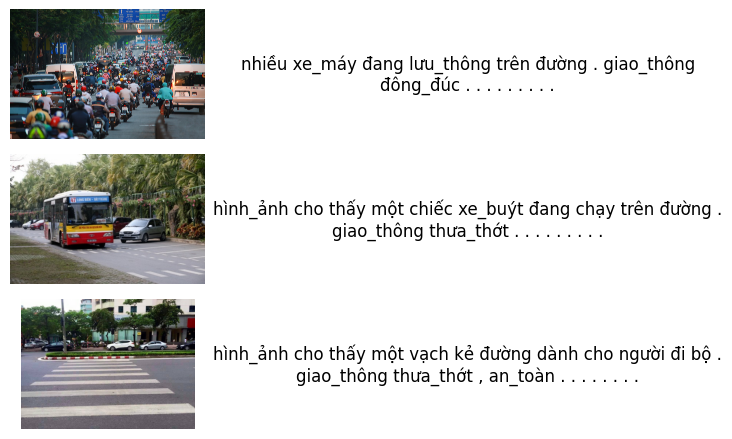

In [60]:
# Danh sách URL ảnh
image_urls = [
    "https://sohanews.sohacdn.com/2020/4/11/39-15865402058191168557332.jpg",
    "https://ecoparker.com/sites/default/files/di%20gi/xe-bus-hanoi-ecopark.jpg",
    "https://s3.cloud.cmctelecom.vn/tinhte1/2016/02/3604342_dibo2.jpg",
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)


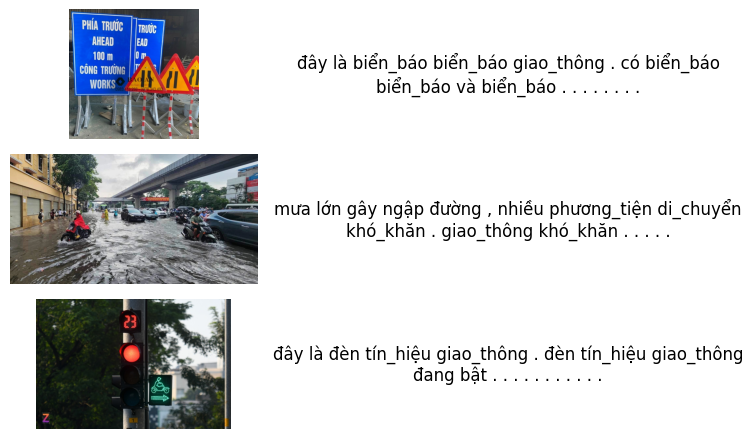

In [61]:
# Danh sách URL ảnh
image_urls = [
    "https://www.vattubaoan.com/Portals/27968/bien-giao-thong.jpg",
    "https://images2.thanhnien.vn/zoom/1200_630/528068263637045248/2024/9/16/edit-nguyen-trai-ngap-17264478816631513171479-97-347-1046-1865-crop-17264487444881246194768.jpeg",
    "https://photo.znews.vn/w660/Uploaded/bpivptvl/2025_03_04/DSC_5899_znews.jpg",
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)

# Evaluate

In [31]:
# from PIL import Image

# # Đường dẫn thư mục chứa các tệp mô hình
# model_path = '/kaggle/working/outputv01'

# # Tải mô hình VisionEncoderDecoder
# model = VisionEncoderDecoderModel.from_pretrained(model_path)

# # Hàm để dự đoán caption cho ảnh
# def predict_internet_caption(model, image_path):
#     response = requests.get(image_path)
#     image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
#     # Đọc ảnh bằng OpenCV
#     image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#     # Chuyển đổi từ BGR (OpenCV) sang RGB
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
#     pixel_values = feature_extractor(image_rgb)
    
#     output_ids = model.generate(
#                 pixel_values
#                 ,max_length=150 
#                 ,min_length=10
#                 ,early_stopping=True
#             )
    
#     caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
#     plt.imshow(image_rgb)
#     return caption

In [32]:
# test_df = df.tail(100)

# # validate với test data
# actual, predicted = {}, {}

# # Duyệt qua từng ảnh trong tập test
# for index, row in tqdm(test_df.iterrows()):
#     # Lấy actual caption từ cột 'caption'
#     captions = [row['caption']]
#     image_url = row['url']
    
#     # Dự đoán caption cho ảnh từ URL
#     y_pred = predict_internet_caption(model, image_url)
    
#     # Thêm các kết quả vào từ điển
#     # Sử dụng chỉ số index làm khóa
#     actual[index] = captions  # Actual captions là danh sách chuỗi
#     predicted[index] = [y_pred]  # Predicted captions là danh sách chứa một chuỗi

In [33]:
# # # Đường dẫn đến file để lưu kết quả
# output_file = "caption_results_25ep_100.json"

# # Tạo cấu trúc dữ liệu cần lưu
# results = {
#     "actual": actual,
#     "predicted": predicted
# }

# # Ghi dữ liệu vào file JSON
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# print(f"Kết quả đã được lưu vào file: {output_file}")


## Evaluate

In [34]:
# Đọc dữ liệu từ file JSON
def load_predict_result(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        loaded_results = json.load(f)

    actual = loaded_results["actual"]
    predicted = loaded_results["predicted"]
    print("Dữ liệu đã được tải lại thành công!")
    return actual, predicted

In [35]:
!pip install rouge-score -q
!pip install pycocoevalcap -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.1 MB/s eta 0:00:00:00:010:01


In [36]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [37]:
# Tính BLEU scores
def bleu_score(actual, predicted):
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_1, bleu_2, bleu_3, bleu_4

In [38]:
def bleu_score_avg(actual, predicted):
    min_key = int(min(actual.keys()))
    max_key = int(max(actual.keys()))
    
    # Khởi tạo danh sách để lưu BLEU score của tất cả các cặp
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    
    for i in range(min_key, max_key + 1):
        actual_caption = actual.get(str(i), [])
        predicted_caption = predicted.get(str(i), [])
        
        if actual_caption and predicted_caption:
            bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score(actual_caption, predicted_caption)
            # Lưu các điểm BLEU vào danh sách
            bleu_1_scores.append(bleu_1)
            bleu_2_scores.append(bleu_2)
            bleu_3_scores.append(bleu_3)
            bleu_4_scores.append(bleu_4)
    
    # Tính trung bình của các BLEU score
    average_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
    average_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
    average_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
    average_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)

    return average_bleu_1, average_bleu_2, average_bleu_3, average_bleu_4


In [39]:
from rouge_score import rouge_scorer

def rouge_score(actual, predicted):
    # Tạo scorer tính các loại ROUGE hợp lệ
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lưu điểm cho từng loại ROUGE
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    # Tính điểm ROUGE cho từng cặp câu
    for index in actual.keys():
        actual_caption = " ".join(actual[index])  # Ghép các từ thành chuỗi
        predicted_caption = " ".join(predicted[index])  # Ghép các từ thành chuỗi

        # Tính điểm cho cặp hiện tại
        scores = scorer.score(actual_caption, predicted_caption)

        # Lưu điểm F1 cho từng loại
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Tính điểm trung bình cho từng loại ROUGE
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_avg = sum(rouge2_scores) / len(rouge2_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    # Trả về ba giá trị ROUGE1, ROUGE2, ROUGEL
    return rouge1_avg, rouge2_avg, rougeL_avg


In [40]:
def evaluate(caption_result_file_name='caption_results_10ep_100.json'):
    actual, predicted = load_predict_result(caption_result_file_name)
    
    bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score_avg(actual, predicted)
    
    rouge1, rouge2, rougeL = rouge_score(actual, predicted)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)
    
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(actual, predicted)
    
    evaluation_scores = {
            'bleu_1': bleu_1,
            'bleu_2': bleu_2,
            'bleu_3': bleu_3,
            'bleu_4': bleu_4,
            'rouge1': rouge1,
            'rouge2': rouge2,
            'rougeL': rougeL,
            'cider_score': cider_score,
            'meteor_score': meteor_score
        }
    return evaluation_scores

In [41]:
# # List để lưu kết quả
# all_results = []

# # Vòng lặp từ 10 đến 24 để xử lý các file
# for i in range(0, 1):
#     # Đọc dữ liệu từ file JSON
#     file_name = f"caption_results_{i}ep_100.json"
    
#     # Gọi hàm evaluate_scores để lấy kết quả cho từng file
#     evaluation_scores = evaluate(file_name)
    
#     # Thêm số lượng epoch vào kết quả
#     evaluation_scores['epoch'] = i
    
#     # Thêm kết quả vào list
#     all_results.append(evaluation_scores)

# # Chuyển danh sách kết quả thành DataFrame
# df_scores = pd.DataFrame(all_results)

# # In DataFrame để kiểm tra
# print(df_scores)


In [42]:
# import matplotlib.pyplot as plt

# # Lựa chọn các cột cần vẽ
# bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
# rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
# cider_meteor_metrics = ['cider_score', 'meteor_score']

# # Vẽ biểu đồ cho từng chỉ số
# def plot_evaluate_score(metrics, title="title"):
#     for metric in metrics:
#         plt.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
#     plt.xlabel('Epoch')
#     plt.ylabel('Score')
#     plt.title(title)
#     plt.legend()
#     plt.grid()
#     plt.show()

# plot_evaluate_score(bleu_metrics, "BLEU Score Over Epochs")
# plot_evaluate_score(rouge_metrics, "ROUGE score Over Epochs")
# plot_evaluate_score(cider_meteor_metrics, "CIDEr - METEOR Over Epochs")


In [43]:
# import matplotlib.pyplot as plt

# # Lựa chọn các cột cần vẽ
# bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
# rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
# cider_meteor_metrics = ['cider_score', 'meteor_score']

# # Hàm vẽ các chỉ số
# def plot_evaluate_scores_subplot(metrics, title, ax):
#     for metric in metrics:
#         ax.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Score')
#     ax.set_title(title)
#     ax.legend()
#     ax.grid()

# # Tạo biểu đồ với subplots
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 hàng, 3 cột, kích thước 18x5

# # Vẽ từng biểu đồ trên các trục riêng
# plot_evaluate_scores_subplot(bleu_metrics, "BLEU Score Over Epochs", axes[0])
# plot_evaluate_scores_subplot(rouge_metrics, "ROUGE Score Over Epochs", axes[1])
# plot_evaluate_scores_subplot(cider_meteor_metrics, "CIDEr - METEOR Over Epochs", axes[2])

# # Hiển thị biểu đồ
# plt.tight_layout()
# plt.show()

In [44]:
# import matplotlib.pyplot as plt

# # Lựa chọn các cột cần vẽ
# bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
# rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
# cider_metrics = ['cider_score']
# meteor_metrics = ['meteor_score']

# # Hàm vẽ các chỉ số
# def plot_evaluate_scores_subplot(metrics, title, ax):
#     for metric in metrics:
#         ax.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Score')
#     ax.set_title(title)
#     ax.legend()
#     ax.grid()

# # Tạo biểu đồ với subplots
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 hàng, 2 cột, kích thước 12x10

# # Vẽ từng biểu đồ trên các trục riêng
# plot_evaluate_scores_subplot(bleu_metrics, "BLEU Score Over Epochs", axes[0][0])
# plot_evaluate_scores_subplot(rouge_metrics, "ROUGE Score Over Epochs", axes[0][1])
# plot_evaluate_scores_subplot(cider_metrics, "CIDEr Score Over Epochs", axes[1][0])
# plot_evaluate_scores_subplot(meteor_metrics, "METEOR Score Over Epochs", axes[1][1])

# # Điều chỉnh khoảng cách
# plt.tight_layout()

# # Lưu hình ảnh
# output_path = "evaluation_scores.png"  # Đường dẫn tệp PNG
# plt.savefig(output_path, format='png', dpi=300)

# # Hiển thị biểu đồ (tùy chọn)
# plt.show()
